# IAD vs Compressibility
In this file, I will calclulate the compressibility of ovlivine and enstatite, and compare the iad evolution with compressibility

## Calculate the compressibility of olivine

> Ref: [root_principal_2018](https://onlinelibrary.wiley.com/doi/abs/10.1029/2017GL076931)

> FUNCTION:
>
> $$P = \rho_0U_sU_p$$
>
> $$\frac{\rho}{\rho_0} = \frac{U_s}{U_s - U_p}$$
>
> $$U_s(U_p) = a + bU_p -cU_p\exp(-dU_p)$$
>
> where $a$ = 6.89 $\pm$ 0.19 km/s, $b$ = 1.22 $\pm$ 0.02, $c$ = 1.50 $\pm$ 0.26, and $d$ = 0.40 $\pm$ 0.05, $\rho_0$ = 3.22 $\pm$ 0.01 g/$cm^3$

In [77]:
from scipy.optimize import fsolve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
from datetime import datetime

In [78]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
date = datetime.now()
date = date.strftime('%m%d%y')
print(date)

050324


In [3]:
def get_comp(us, us_err, up, up_err):
    comp = us/(us-up)
    comp_err = comp*np.sqrt((us_err/us)**2 + (up_err/(us-up))**2)
    return comp, comp_err
    
def equations(vars, P, rho_0, a, b, c, d):
    us, up = vars
    eq1 = P - rho_0 * us * up
    eq2 = us - a - b * up + c * up * np.exp(-d * up)
    return [eq1, eq2]

def get_u(P, rho_0, a, b, c, d):
    initial_guess = [1.0, 1.0]  # Initial guess for s and u
    us, up = fsolve(equations, initial_guess, args=(P, rho_0, a, b, c, d))
    return us, up
def get_u_err(P, P_err, rho_0, a, b, c, d, num_samples = 1000):
    us_samples = []
    up_samples = []
    
    for _ in range(num_samples):
        # Perturb parameters with uncertainties
        #P_perturbed = np.random.normal(P, P_err)
        rho_perturbed = np.random.normal(rho_0, 0.01) 
        a_perturbed = np.random.normal(a, 0.19)  
        b_perturbed = np.random.normal(b, 0.02) 
        c_perturbed = np.random.normal(c, 0.26) 
        d_perturbed = np.random.normal(d, 0.05)  
        
        # Solve equations with perturbed parameters
        initial_guess = [1.0, 1.0]  # Initial guess for s and u
        us, up = fsolve(equations, initial_guess, args=(P, rho_perturbed, a_perturbed, b_perturbed, c_perturbed, d_perturbed))
        
        us_samples.append(us)
        up_samples.append(up)
    us_mean = np.mean(us_samples)
    us_std = np.std(us_samples)
    up_mean = np.mean(up_samples)
    up_std = np.std(up_samples)
        
    
    return us_mean, us_std, up_mean, up_std

#### parameters for HUgoniot equation of olivine

In [4]:
rho_0 = 3.22
a = 6.89; b = 1.22; c = 1.50; d = 0.4

In [5]:
ol = pd.read_csv('ol_iad_xwei.csv')
ol.head()

,run_num,pressure,p_err,iad_kb,iad_kbst,hugoniot
0,174,86.187817,57.031965,0.192267,0.032156,True
1,90,70.156394,44.014597,0.158571,0.020602,False
2,161,173.169106,57.032614,0.173252,0.035009,True
3,282,178.208551,0.000000,0.214408,0.040704,False
4,85,141.205274,26.045756,0.209889,0.041590,False


In [6]:
comp_ol=[]; comp_err_ol = []
us_ol = []; us_err_ol = []; 
up_ol = []; up_err_ol = []
for i in range(len(ol['pressure'])):
    us_mean, us_std, up_mean, up_std = get_u_err(ol['pressure'][i], ol['p_err'][i], rho_0, a, b, c, d)
    us_ol.append(us_mean)
    us_err_ol.append(us_std)
    up_ol.append(up_mean)
    up_err_ol.append(up_std)
    result = get_comp(us_mean, us_std, up_mean, up_std)
    comp_ol.append(result[0])
    comp_err_ol.append(result[1])

Text(0.5, 1.0, '$K\\beta_{st}$')

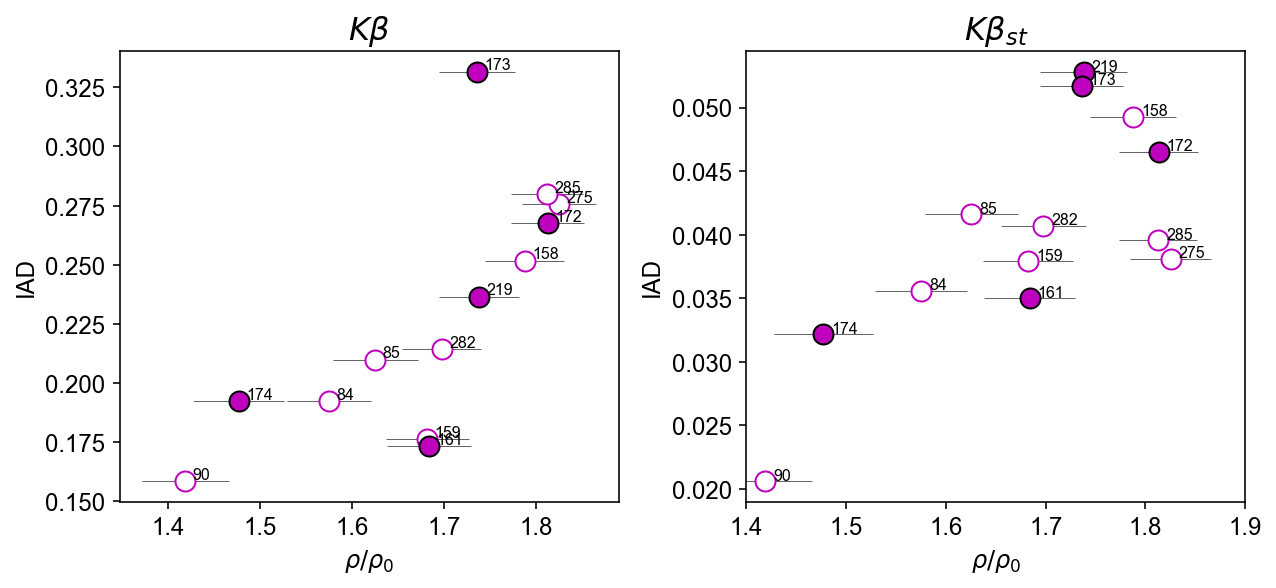

In [86]:
face = {True: 'm', False:'w'}
edge = {True:'k', False:'m'}
zorder = {True: 100, False: 1}
shift = {0:0.001, 1:0.0001}
f, ax = plt.subplots(1, 2, figsize = (9,4))
#plt.rcParams['font.size'] = 12
for i in range(len(comp_ol)):
    y = [ol['iad_kb'][i], ol['iad_kbst'][i]]
    for idx, y in enumerate(y): 
        ax[idx].errorbar(comp_ol[i], y, xerr = comp_err_ol[i], ls = '',marker = 'o',mec = edge[ol['hugoniot'][i]],
                   mfc =face[ol['hugoniot'][i]], mew = 1., color = 'k', lw = 0.3, ms = 10, zorder = zorder[ol['hugoniot'][i]])
        ax[idx].text(comp_ol[i]+0.008, y+ shift[idx], ol['run_num'][i], fontsize =8)
        ax[idx].set_xlabel(r'$\rho/\rho_0$')
        ax[idx].set_ylabel('IAD')
plt.xlim(1.4, 1.9)
plt.tight_layout()
ax[0].set_title(r'$K\beta$', fontsize = 16)  
ax[1].set_title(r'$K\beta_{st}$', fontsize = 16) 

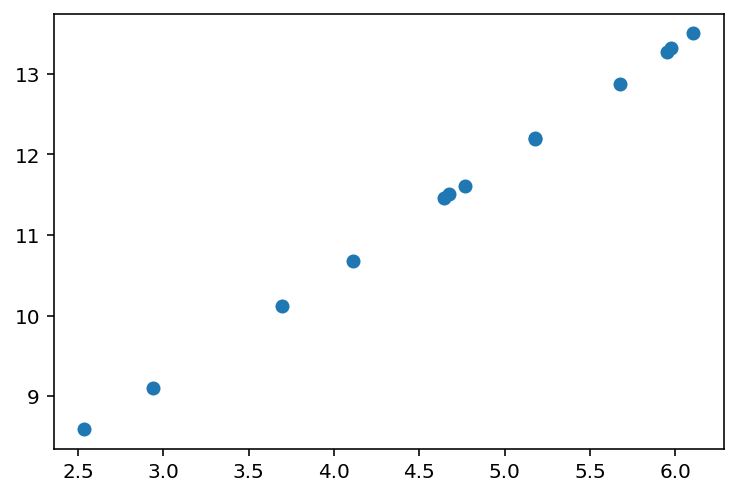

In [8]:
plt.scatter(up_ol, us_ol)

In [9]:
ens_up = pd.read_csv('../../LCLS-2022/jupyter/calculated-Up.csv')
ens_us = pd.read_csv('../../LCLS-2022/jupyter/calculated-Us.csv')

run_num, up, up_err, type, release = ens_up.iloc[:, :5].T.values
us, us_err = ens_us.iloc[:, 1:3].T.values

In [10]:
fl_ls = glob.glob('../../LCLS-2022/jupyter/iad_stdref_data/*-dict.json')
fl_kbst= []; fl_kb= []
for f in fl_ls: 
    if len(f.split('kb_')[1])== 16:
        fl_kbst.append(f)
    else:
        fl_kb.append(f)

In [11]:
def read_info_json(json_filen):
    f = open(json_filen)
    iad_dict = json.load(f)
    f.close()
    return iad_dict
def get_iad(f_list, run_num):
    for f in f_list:
        data = read_info_json(f)
        if data['sample run number'] == run_num:
            iad = data['iad smooth']
            break
    return iad

Text(0, 0.5, 'Us')

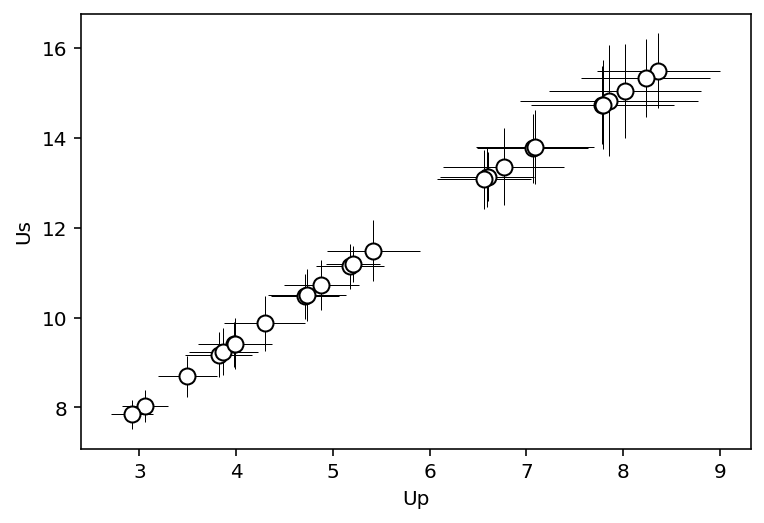

In [12]:
plt.errorbar(up, us, xerr = up_err, yerr = us_err, ls = '', marker = 'o', 
             mec = 'k', mfc = 'w',ms = 8, color = 'k', lw = 0.5)
plt.xlabel('Up')
plt.ylabel('Us')

### Get compresibility of enstatitle by

>$$\frac{\rho}{\rho_0} = \frac{U_s}{U_s - U_p}$$
>
>I have got values of Us and Up from Ali

In [13]:
comp_ens = []; comp_err_ens =[]
for i in range(len(us)):
    comp = get_comp(us[i], us_err[i], up[i], up_err[i])
    comp_ens.append(comp[0])
    comp_err_ens.append(comp[1])

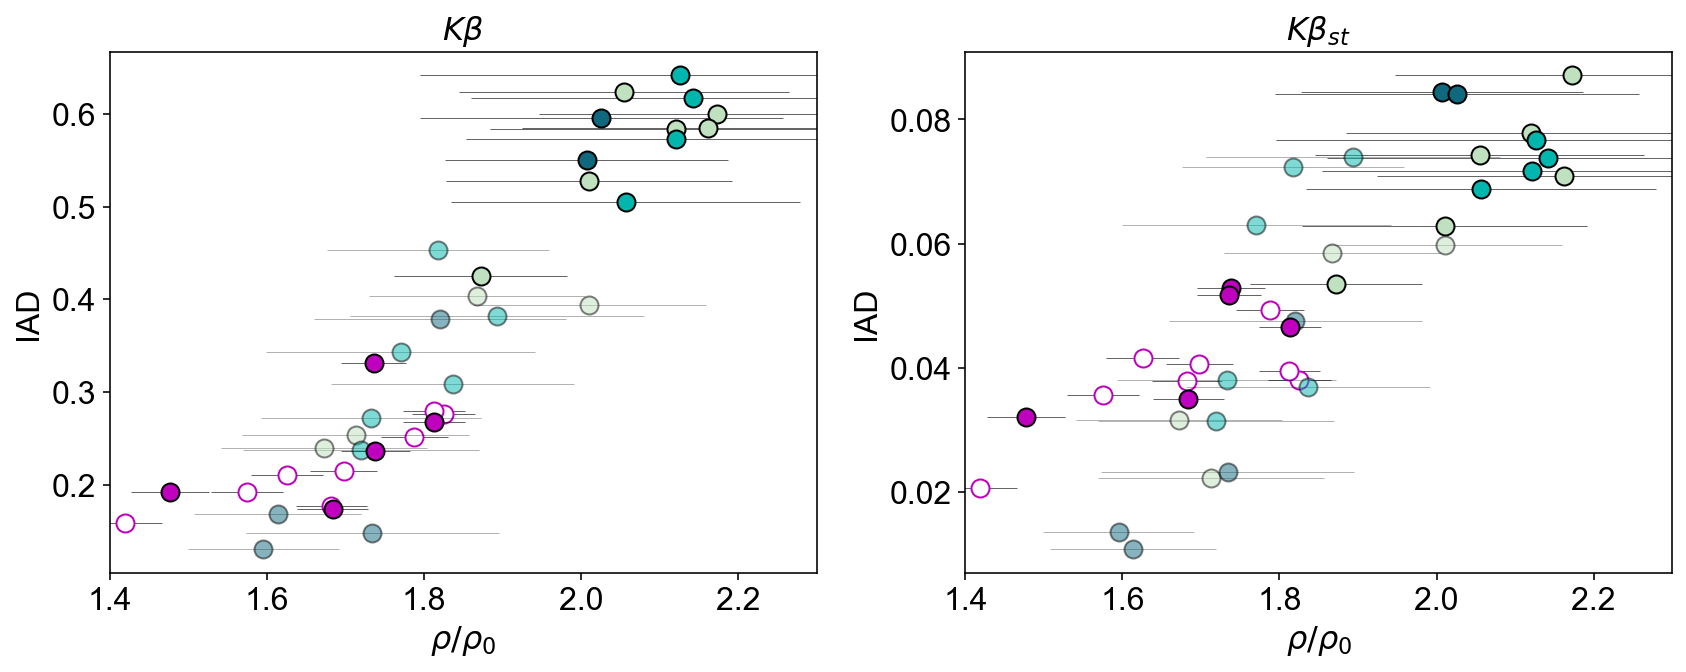

In [79]:
c = {'fe05': '#bfe1bf', 'fe10':'#01B6AD', 'fe20': '#10687E'}
plt.rcParams['font.family'] = 'Arial' 
plt.rcParams['font.size'] = 16
alpha = {True: 0.5, False: 1}
face = {True: 'm', False:'w'}
edge = {True:'k', False:'m'}
zorder = {True: 100, False: 1}
f, ax = plt.subplots(1,2, figsize = (12,5))
for i in range(len(run_num)):
    iad_kb = get_iad(fl_kb,str(run_num[i]))
    iad_kbst = get_iad(fl_kbst,str(run_num[i]))
    y= [iad_kb, iad_kbst]
    for idx, y in enumerate(y):
        ax[idx].errorbar(comp_ens[i], y, xerr = comp_err_ens[i], ls = '',marker = 'o', ms = 9, mfc = c[type[i]], 
                   mec = 'k', color = 'k', lw = 0.3, alpha = alpha[release[i]])
        ax[idx].set_xlim(1.4, 2.3)
        ax[idx].set_xlabel(r'$\rho/\rho_0$')
        ax[idx].set_ylabel('IAD')
for i in range(len(comp_ol)): 
    y = [ol['iad_kb'][i], ol['iad_kbst'][i]]
    for idx, y in enumerate(y):
        ax[idx].errorbar(comp_ol[i], y, xerr =  comp_err_ol[i], ls = '',marker = 'o', mec = edge[ol['hugoniot'][i]],
                   mfc =face[ol['hugoniot'][i]], mew = 1., color = 'k', lw = 0.3, ms = 9,
                         zorder = zorder[ol['hugoniot'][i]])
    
ax[0].set_title(r'$K\beta$', fontsize = 16)  
ax[1].set_title(r'$K\beta_{st}$', fontsize = 16) 
plt.tight_layout()
plt.savefig('./figs/ol_ens_iad_vs_rho' + date + '.png', bbox_inches = 'tight', dpi = 200)

Text(0.5, 1.0, '$K\\beta_{st}$')

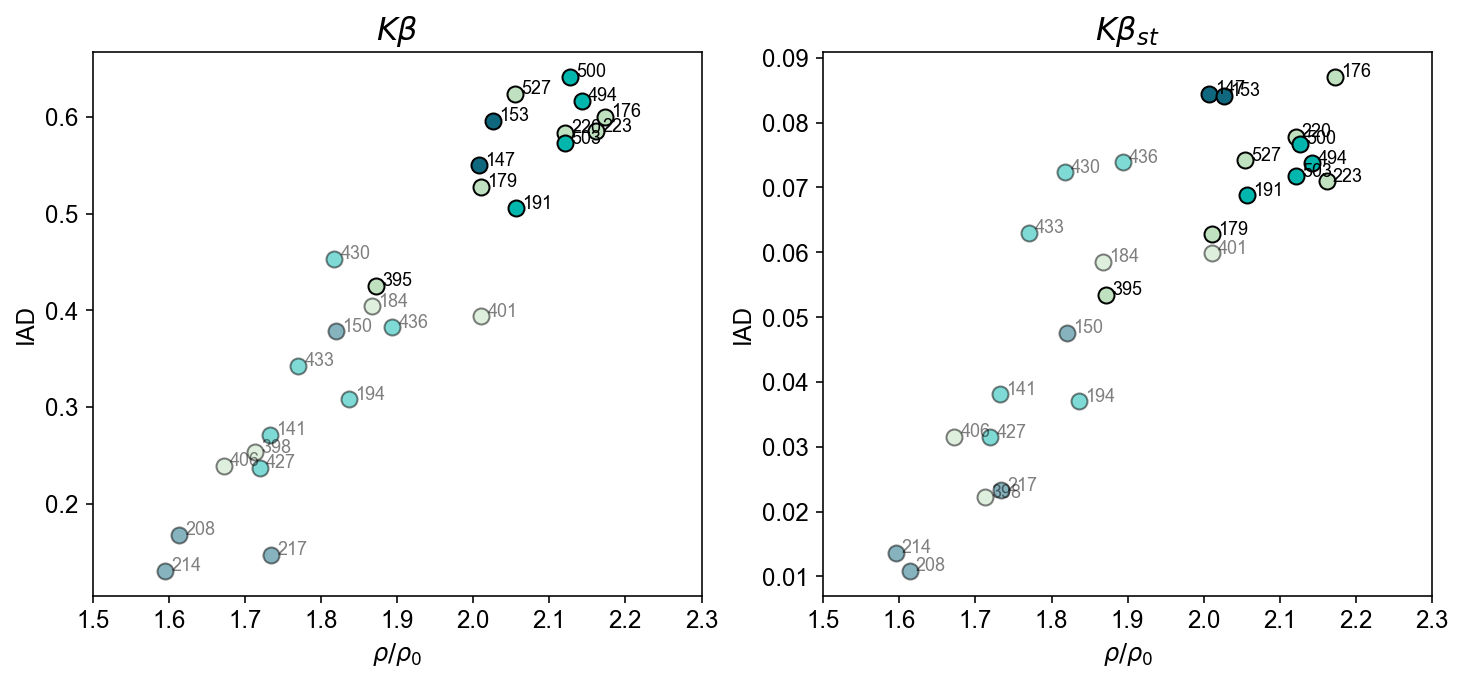

In [70]:
f, ax = plt.subplots(1,2, figsize = (12,5))
for i in range(len(run_num)):
    iad_kb = get_iad(fl_kb,str(run_num[i]))
    iad_kbst = get_iad(fl_kbst,str(run_num[i]))
    y= [iad_kb, iad_kbst]
    for idx, y in enumerate(y):
        ax[idx].plot(comp_ens[i], y,  ls = '',marker = 'o', ms = 8, mfc = c[type[i]], 
                   mec = 'k', color = 'k', lw = 0.3, alpha = alpha[release[i]])
        ax[idx].text(comp_ens[i]+0.008, y, run_num[i], fontsize = 9, alpha =alpha[release[i]])
        ax[idx].set_xlim(1.5, 2.3)
        ax[idx].set_xlabel(r'$\rho/\rho_0$')
        ax[idx].set_ylabel('IAD')
ax[0].set_title(r'$K\beta$', fontsize = 16)  
ax[1].set_title(r'$K\beta_{st}$', fontsize = 16) 